**weather_data_hour**함수는 아래 github의 내용과 같은 과정에 따라 만들어졌습니다. [[github]](https://github.com/TAEJIN-AHN/Electricity-Load-Prediction/blob/75f9fa88c9d52564ed28664b5ffe8616f9e46856/notebook/weather_data_hour.md)



In [ ]:
def weather_data_hour(raw_weather_data_path):
  
  # 패키지 불러오기

  import pandas as pd
  import numpy as np

  weather = pd.read_csv(raw_weather_data_path)

  # 실질적인 결측치 (-9, -99, '-')의 비율이 적은 특성만 사용
  weather = weather[['datetime', 'STN_ID', 'STN', 'PS_hPa', 'PA_hPa', 'IR_nan', 'CA_TOT', 'TA_C',
                    'WS_m/s', 'PV_hPa', 'HM_%', 'WD_16', 'TS_C', 'TD_C', 'VS_nan', 'CA_MID']]

  # 광역시, 특별시 데이터만 사용
  weather = weather[weather['STN'].isin(['서울', '부산', '인천', '대구', '대전', '광주', '울산'])]

  # 동일한 Time index로 통일하기
  STN_list = list(weather['STN'].unique())
  time_list = pd.date_range('2013-1-1 00:00',periods = 90876, freq='h')

  for idx, STN in enumerate(STN_list):
    tmp = pd.DataFrame(columns = ['datetime'])
    tmp['datetime'] = [str(time)[:-3] for time in time_list]
    tmp = pd.merge(tmp, weather[weather['STN']==STN], on = 'datetime', how = 'left')
    if idx == 0:
      aligned_weather = tmp
    else:
      aligned_weather = pd.concat([aligned_weather, tmp])

  # 결측치(nan)나 실질적인 결측치(-9, -99, '-')를 보간법으로 채우기
  STN_list = list(aligned_weather['STN'].unique())
  column_list = list(aligned_weather.columns.values)[3:]

  for idx, STN in enumerate(STN_list):
    # ① 각 STN별로 데이터 나누기
    tmp = aligned_weather[aligned_weather['STN'] == STN]

    # ② 시간순으로 정렬하기
    tmp = tmp.sort_values(by='datetime')

    # ③ -9나 -99인 값을 Null값으로 바꾸기
    for column in column_list:

      if column in ['TA_C', 'TS_C', 'TD_C']:
        # 온도값은 -99가 Null값
        tmp.replace({column : {-99 : np.nan}}, inplace = True)
      else:
        # 온도가 아닌 값은 -9가 Null값
        tmp.replace({column : {-9 : np.nan}}, inplace = True)
                    
    for column in column_list:
      # ④ Pandas Interpolate로 보간법 사용하여 Null값 채우기
      if column in ['WD_16', 'CA_TOT', 'CA_MID', 'VS_nan', 'IR_nan']:
        # 이산형 변수는 최근접 이웃 보간법 사용
        tmp[column] = tmp[column].interpolate(method='nearest')
      else:
        # 연속형 변수는 선형 보간법 사용
        tmp[column] = tmp[column].interpolate(method='linear')

    # ⑤ tmp 합치기
    if idx == 0:
      interpolated_weather = tmp
    else:
      interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 중앙값과 평균으로 전국 기상 대표값 정하기

  column_list = list(interpolated_weather.columns.values)[3:]

  for idx, column in enumerate(column_list):
    # ① 컬럼별로 grouby 수행 (중앙값과 평균값 특성별로 다르게 사용)
    if column in ['WD_16', 'CA_TOT', 'CA_MID', 'VS_nan', 'IR_nan']:
      tmp = pd.DataFrame(interpolated_weather.groupby('datetime', as_index = False)[column].median())
    else:
      tmp = pd.DataFrame(interpolated_weather.groupby('datetime', as_index = False)[column].mean())
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = 'datetime', how = 'inner')
    
  return representative_weather

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/weather_20130101_20230515.csv'
representative_weather = weather_data_hour(path)

In [ ]:
# 요일 특성 반영 (더미변수로 반영)
# 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

import pandas as pd
representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])

In [ ]:
# 휴일 특성 반영
# 휴일이 아니면 0, 휴일이면 1

holiday = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/time/holidays.csv')

for row_number in range(representative_weather.shape[0]):
  if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
    representative_weather.at[row_number, 'holiday'] = 1
  else:
    representative_weather.at[row_number, 'holiday'] = 0

In [ ]:
# 월 정보 반영 (더미변수로 반영)

representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

In [ ]:
time_column_list = list(representative_weather.columns.values[14:])

전력 데이터의 시간 인덱스를 기상인자 데이터와 동일한 형식으로 변환합니다.

In [ ]:
import pandas as pd

power = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/load_supply/power_demand_1hour.csv').melt(id_vars = '날짜')
power.columns = ['datetime', 'hour', 'load']

for row_number in range(power.shape[0]):
  if len(power.at[row_number, 'hour']) == 3:
    if power.at[row_number, 'hour'] == '24시':
      power.at[row_number, 'new_datetime'] = power.at[row_number, 'datetime'] + ' ' + '00:00'
    else:
      power.at[row_number, 'new_datetime'] = power.at[row_number, 'datetime'] + ' ' + power.at[row_number, 'hour'][:-1] + ':00'
  else:
     power.at[row_number, 'new_datetime'] = power.at[row_number, 'datetime'] + ' ' + '0' + power.at[row_number, 'hour'][:-1] + ':00'

power = power.drop(['datetime', 'hour'], axis = 1)
power.columns = ['load', 'datetime']
power = power[['datetime', 'load']]

In [ ]:
power.to_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/load_supply/power_demand_1hour_reshaped.csv')

* 시간별 전력 수요와 기상 인자 각각의 산포도를 그려봤을 때, **이슬점 온도, 지표 온도, 기온, 수증기압**에서 비교적 강한 상관관계가 나타났습니다,
* 모두 2차 함수의 특징을 가지고 있으며 온도나 기압이 양극단으로 갈 수록 전력 수요가 높아집니다.

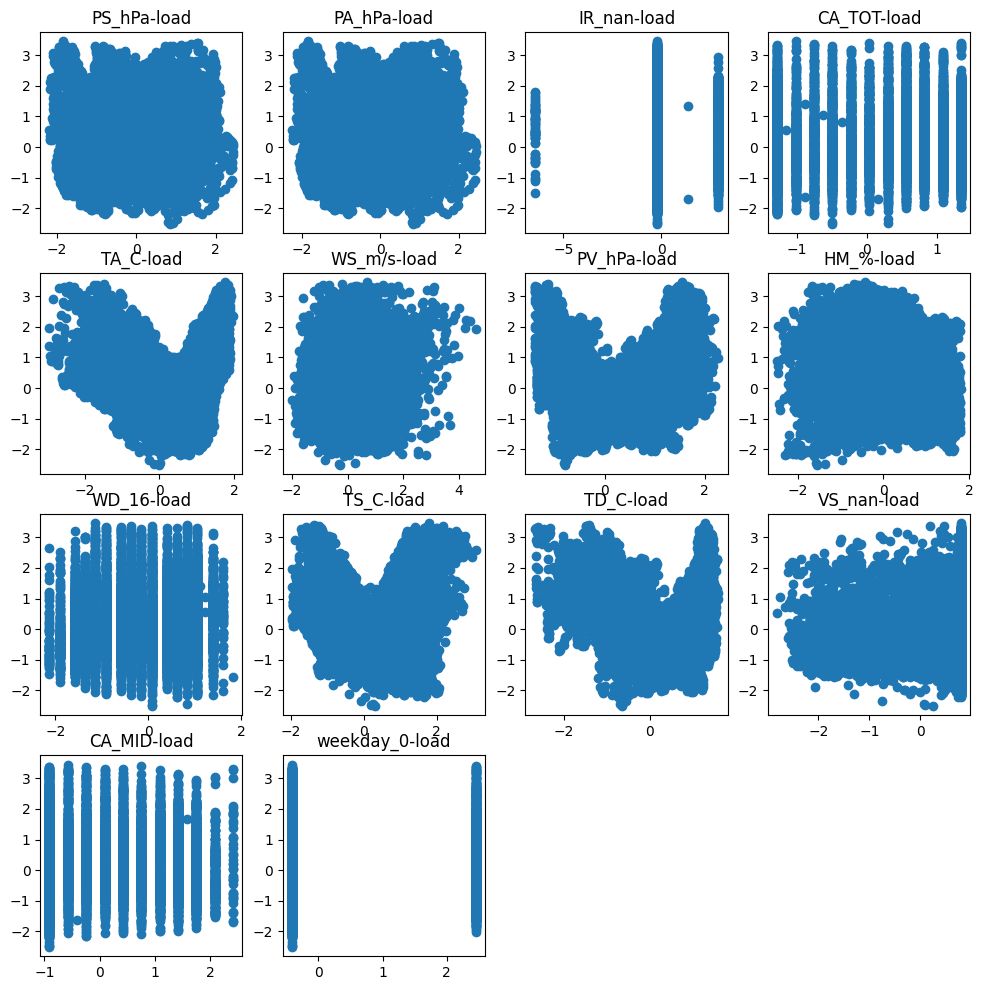

In [ ]:
target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
scaled_target_df = pd.DataFrame(scaler.fit_transform(target_df.iloc[:,1:]), columns = target_df.columns.values[1:]).iloc[-8640:,:]

plt.figure(figsize = (12, 12))
for idx, column in enumerate(list(scaled_target_df.columns.values[:14])):
  plt.subplot(4, 4, idx+1)
  plt.title(column + '-load')
  plt.scatter(scaled_target_df[column], scaled_target_df['load'])

# 상관관계가 비교적 뚜렷한 기상인자와 전력 수요 데이터로 학습 데이터셋 확정

target_df = target_df[['datetime', 'TA_C', 'TS_C', 'TD_C', 'PV_hPa'] + time_column_list + ['load']]

이번 모델링에는 전력수요 데이터와 상기 분석에서 전력 수요와 높은 상관관계를 가졌다고 확인된 4개 기상인자 (기온, 지표온도, 이슬점온도, 수증기압) 및 요일 특성, 휴일 여부, 월, 일을 사용합니다.

In [ ]:
# 학습 및 테스트 데이터 생성

import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split

ss_1 = MinMaxScaler()
ss_2 = MinMaxScaler()
dataset_1 = pd.DataFrame(ss_1.fit_transform(target_df.iloc[:,1:5]))
dataset_2 = target_df.iloc[:,5:-1]
dataset_3 = pd.DataFrame(ss_2.fit_transform(np.array(target_df['load']).reshape(-1, 1)))
dataset = pd.concat([dataset_1, dataset_2, dataset_3], axis = 1)

X, y = list(), list()

for i, _ in tqdm(dataset.iterrows(), total = dataset.shape[0]):
  idx_in = i + 48 # sequece_length = 48(hours)
  idx_out = idx_in + 6 # step_length = 6(hours)
  if idx_out > len(dataset):
    break
  seq_x = dataset.iloc[i:idx_in, :]
  seq_y = dataset.iloc[idx_in:idx_out, -1]
  X.append(seq_x)
  y.append(seq_y)

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

100%|█████████▉| 78835/78888 [00:17<00:00, 4551.80it/s]


In [ ]:
# 학습 및 테스트 데이터 Tensor로 변환한 뒤 Dataloader 만들기

import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.FloatTensor(X_train).cuda()
y_train_tensor = torch.FloatTensor(y_train).cuda()

X_test_tensor = torch.FloatTensor(X_test).cuda()
y_test_tensor = torch.FloatTensor(y_test).cuda()

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True, drop_last = True)

In [ ]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([63068, 48, 46]),
 torch.Size([63068, 6]),
 torch.Size([15767, 48, 46]),
 torch.Size([15767, 6]))

In [ ]:
import torch.nn as nn

# 모델 구성하기

input_dim = 46 # 입력 컬럼의 개수
hidden_dim = 150 # 은닉 상태의 개수
output_dim = 6 # 출력 값의 개수(형태)
learning_rate = 0.00001 # 학습률
nb_epochs = 500 # 에포크의 수
seq_length = 48 # sequence의 길이 (몇시간 치의 데이터가 들어오는가)

class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_len, out_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
    )
  
  def forward(self, x):
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [ ]:
!pip install torchmetrics -q

In [ ]:
# 모델 학습 함수 만들기

# !pip install torchmetrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for batch_idx, samples in enumerate(train_df):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss (1hour ~ 6hour):', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

In [ ]:
# 모델 학습

net = Net(input_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs,
                                lr = learning_rate, verbose = 5, patience = 30)

Epoch: 0000 train loss (1hour ~ 6hour): 5.1909
Epoch: 0005 train loss (1hour ~ 6hour): 1.3582
Epoch: 0010 train loss (1hour ~ 6hour): 0.3413
Epoch: 0015 train loss (1hour ~ 6hour): 0.3111
Epoch: 0020 train loss (1hour ~ 6hour): 0.2952
Epoch: 0025 train loss (1hour ~ 6hour): 0.2883
Epoch: 0030 train loss (1hour ~ 6hour): 0.2841
Epoch: 0035 train loss (1hour ~ 6hour): 0.2798
Epoch: 0040 train loss (1hour ~ 6hour): 0.2967
Epoch: 0045 train loss (1hour ~ 6hour): 0.2333
Epoch: 0050 train loss (1hour ~ 6hour): 0.2779
Epoch: 0055 train loss (1hour ~ 6hour): 0.2055
Epoch: 0060 train loss (1hour ~ 6hour): 0.2480
Epoch: 0065 train loss (1hour ~ 6hour): 0.2027
Epoch: 0070 train loss (1hour ~ 6hour): 0.2318
Epoch: 0075 train loss (1hour ~ 6hour): 0.2229
Epoch: 0080 train loss (1hour ~ 6hour): 0.1961
Epoch: 0085 train loss (1hour ~ 6hour): 0.1801
Epoch: 0090 train loss (1hour ~ 6hour): 0.1607
Epoch: 0095 train loss (1hour ~ 6hour): 0.2100
Epoch: 0100 train loss (1hour ~ 6hour): 0.1633
Epoch: 0105 t

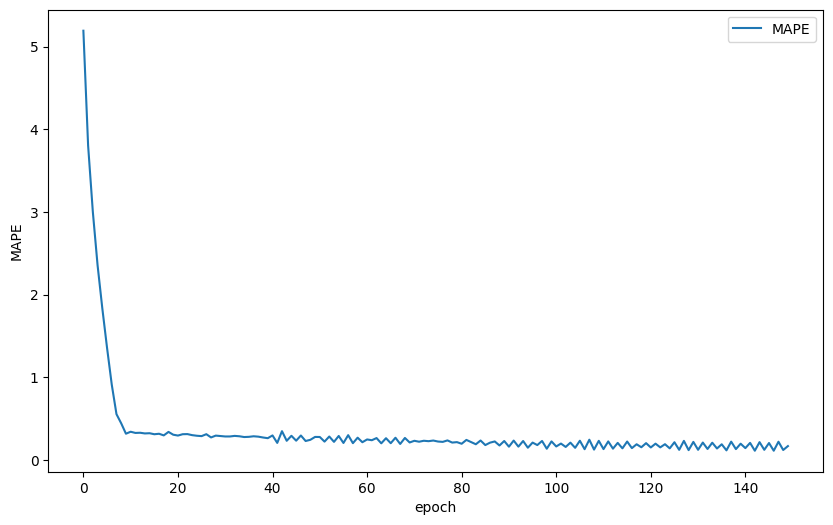

In [ ]:
# 학습 중 MAPE 추이 확인

fig = plt.figure(figsize = (10,6))
plt.plot(train_hist[:150], label = 'MAPE')
plt.xlabel('epoch')
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [ ]:
# 모델 테스트

# 예측 테스트
with torch.no_grad(): 
    for pr in range(len(X_test_tensor)):
        model.reset_hidden_state()
        predicted = model(torch.unsqueeze(X_test_tensor[pr], 0)).to('cpu') 
        # 입력 데이터가 3차원이었기에 맞춰주어야 함 (unsqueeze)
        if pr == 0:
          pred = predicted
        else:
          pred = torch.cat([pred, predicted], dim = 0)

    # INVERSE
    pred_inverse = ss_2.inverse_transform(np.array(pred))
    testY_inverse = ss_2.inverse_transform(y_test_tensor.to('cpu'))

def MAPE(true, pred):
    return [np.mean(np.abs((true-pred)/true)[:,0]),
            np.mean(np.abs((true-pred)/true)[:,1]),
            np.mean(np.abs((true-pred)/true)[:,2]),
            np.mean(np.abs((true-pred)/true)[:,3]),
            np.mean(np.abs((true-pred)/true)[:,4]),
            np.mean(np.abs((true-pred)/true)[:,5])]

print('MAPE SCORE : ', MAPE(testY_inverse, pred_inverse))

MAPE SCORE :  [0.0225761974315035, 0.023543097832959013, 0.023157689726493562, 0.023808874876747724, 0.025453350448923894, 0.028147634696626768]


In [ ]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/model_20230518.pth')